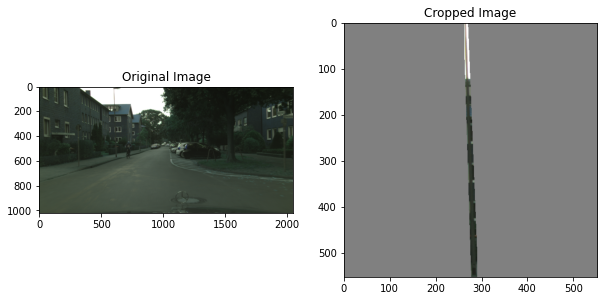

In [13]:
import torch
import torch.nn as nn
from tools.configer import Configer
from lib.get_dataloader import get_data_loader
import cv2
import numpy as np
import matplotlib.pyplot as plt
import clip
from PIL import Image
import lib.transform_cv2 as T
import torch.nn.functional as F

configer = Configer(configs='configs/clip_city_cam_a2d2_eval.json')
# clip_model, _ = clip.load("ViT-B/32", device="cuda")

# lb_name = configer.get("unify_classes_name")
# lb_name = ["a photo of " + name + "." for name in lb_name]
# text = clip.tokenize(lb_name).cuda()
# text_features = clip_model.encode_text(text).type(torch.float32)

n_datasets = configer.get("n_datasets")

num_classes = []
for i in range(1, n_datasets + 1):
    num_classes.append(configer.get("dataset" + str(i), "n_cats"))

dl_city, dl_cam, dl_a2d2 = get_data_loader(configer, aux_mode='ret_path', distributed=False)

city_img_lists = []
city_lb_lists = []
for label_id in range(0, num_classes[0]):
    img_count = 0

    city_img_list = []
    city_lb_list = []
    for im, lb in dl_city:
        im = im[0]
        lb = lb.squeeze()
        if (lb == label_id).any():
            city_img_list.append(im)
            city_lb_list.append(lb)
            img_count += 1
            if img_count == 10:
                break
    city_img_lists.append(city_img_list)
    city_lb_lists.append(city_lb_list)


# cam_img_lists = []
# cam_lb_lists = []
# for label_id in range(0, num_classes[1]):
#     img_count = 0
#     cam_img_list = []
#     cam_lb_list = []
#     for im, lb in dl_cam:
#         if (lb == label_id).any():
#             cam_img_list.append(im)
#             cam_lb_list.append(lb)
#             img_count += 1
#             if img_count == 10:
#                 break
#     cam_img_lists.append(cam_img_list)
#     cam_lb_lists.append(cam_lb_list)

# a2d2_img_lists = []
# a2d2_lb_lists = []
# for label_id in range(0, num_classes[2]):
#     img_count = 0
#     a2d2_img_list = []
#     a2d2_lb_list = []
#     for im, lb in dl_a2d2:
#         if (lb == label_id).any():
#             a2d2_img_list.append(im)
#             a2d2_lb_list.append(lb)
#             img_count += 1
#             if img_count == 10:
#                 break
#     a2d2_img_lists.append(a2d2_img_list)
#     a2d2_lb_list.append(a2d2_lb_list)
    

# cv2.imshow('Cropped Image', cropped)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


    
def crop_image_by_label_value(img, label, label_value):
    # 将标签二值化
    binary = np.zeros_like(label)
    binary[label == label_value] = 255

    binary = cv2.convertScaleAbs(binary)
    
    # 执行闭运算操作
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    # 计算轮廓
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    
#     # 找到覆盖所有轮廓的最小矩形
#     max_rect = cv2.minAreaRect(np.concatenate(contours))
    
#     # 获取最大包围盒的坐标
#     x, y, w, h = cv2.boundingRect(np.int0(cv2.boxPoints(max_rect)))
#     print(x, y, w, h)

    # 计算每个包围盒的面积并找到面积最大的包围盒
    max_area = 0
    max_bbox = None
    for contour in contours:
        bbox = cv2.boundingRect(contour)
        area = bbox[2] * bbox[3]
        if area > max_area:
            max_area = area
            max_bbox = bbox

    # 如果没有找到任何包围盒，返回空图像
    if max_bbox is None:
        return np.zeros_like(image)

    # 裁剪图像
    x, y, w, h = max_bbox

#     # 获取包围盒
#     x, y, w, h = cv2.boundingRect(contours[4])
#     print(x, y, w, h)
    
    # 裁剪图像
    # print(img.shape)
    cropped = img[y:y+h, x:x+w, :]
    
    # 将不属于该标签的像素点替换为指定的值
    label_roi = binary[y:y+h, x:x+w]
    
    k = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(label_roi, kernel=k)
    
    
    mask = np.ones_like(cropped, dtype=bool)
    mask[dilated != 255] = False
    cropped[~mask] = 128
    
    h, w, _ = cropped.shape
    if h < w:
        top_padding = (w - h) // 2
        bottom_padding = w - h - top_padding
        cropped = cv2.copyMakeBorder(cropped, top_padding, bottom_padding, 0, 0, cv2.BORDER_CONSTANT, value=[128, 128, 128])
    elif h > w:
        left_padding = (h - w) // 2
        right_padding = h - w - left_padding
        cropped = cv2.copyMakeBorder(cropped, 0, 0, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[128, 128, 128])
        
    # 返回裁剪后的图像
    return cropped

im_path = city_img_lists[0][0]
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = clip.load("ViT-B/32", device=device)

ori_image = cv2.imread(im_path)

lb = city_lb_lists[0][0].numpy()

to_tensor = T.ToTensor(
            mean=(0.48145466, 0.4578275, 0.40821073), # clip , rgb
            std=(0.26862954, 0.26130258, 0.27577711),
        )

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(ori_image)
axes[0].set_title('Original Image')
cropped_img = crop_image_by_label_value(ori_image, lb, 5)

im_lb = dict(im=cropped_img, lb=lb)
im_lb = to_tensor(im_lb)
img = im_lb['im'].cuda()
# _, h, w = img.shape
# print(img.shape)
img = F.interpolate(img.unsqueeze(0), size=(224, 224))
# if h > w:
#     resize_w = int(224 * w / h)
#     img = F.interpolate(img.unsqueeze(0), size=(224, resize_w))
#     left_padding = (224 - resize_w) /2
#     right_padding = 224 - resize_w - left_padding
#     pad = nn.ZeroPad2d(padding=(left_padding, right_padding, 0, 0), value=0)
# else:
#     img = F.interpolate(img.unsqueeze(0), size=(int(224 * h / w), 224))
    


# lb = im_lb['lb']



# 显示裁剪前后的图像

axes[1].imshow(cropped_img)
axes[1].set_title('Cropped Image')
plt.show()

torch.Size([19, 10, 512])
(24, 24)


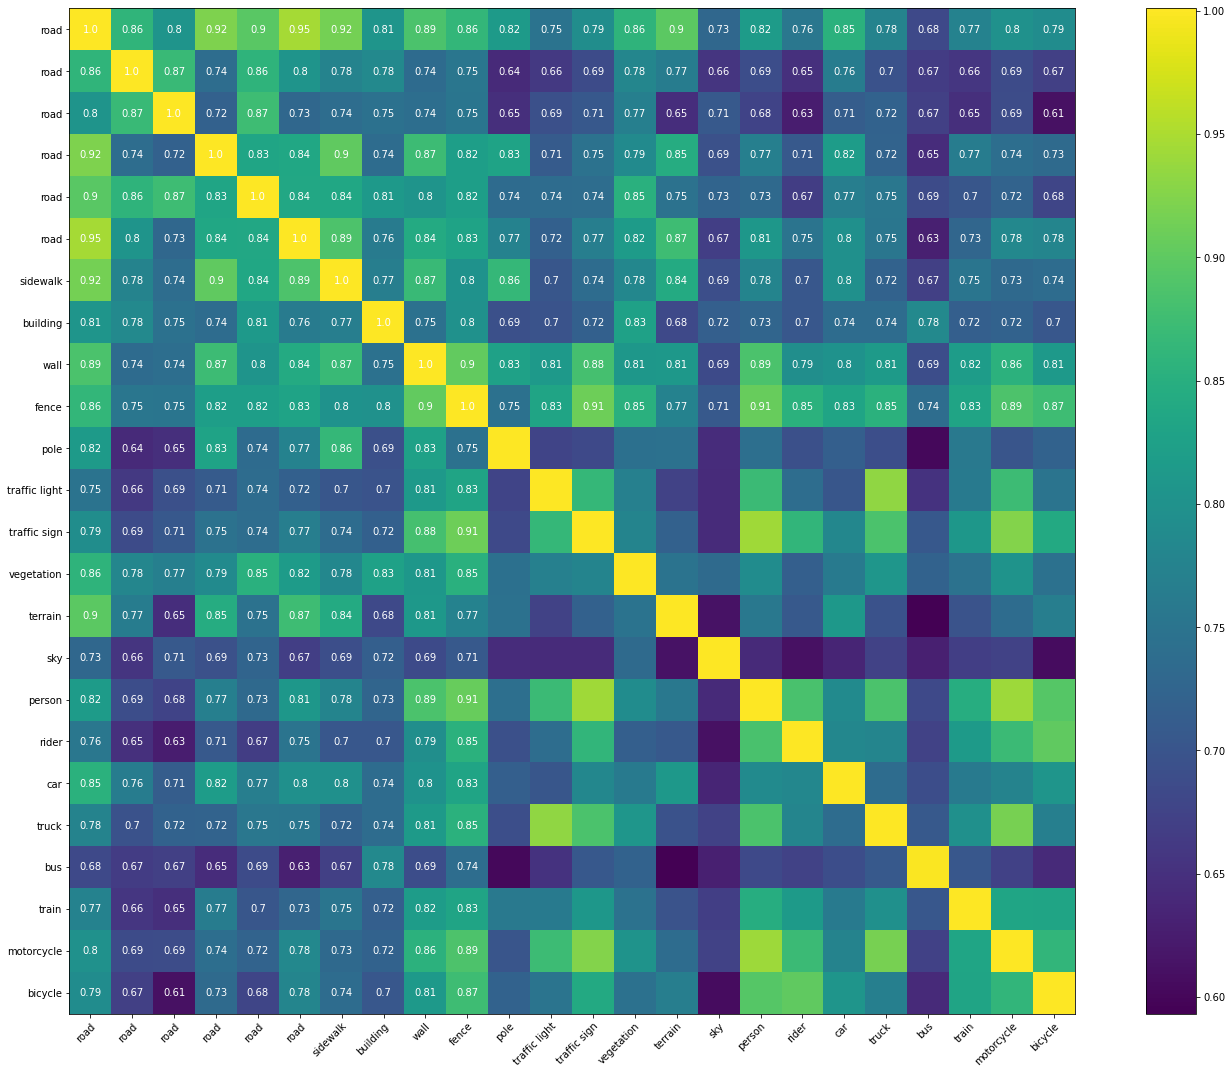

(24, 24)


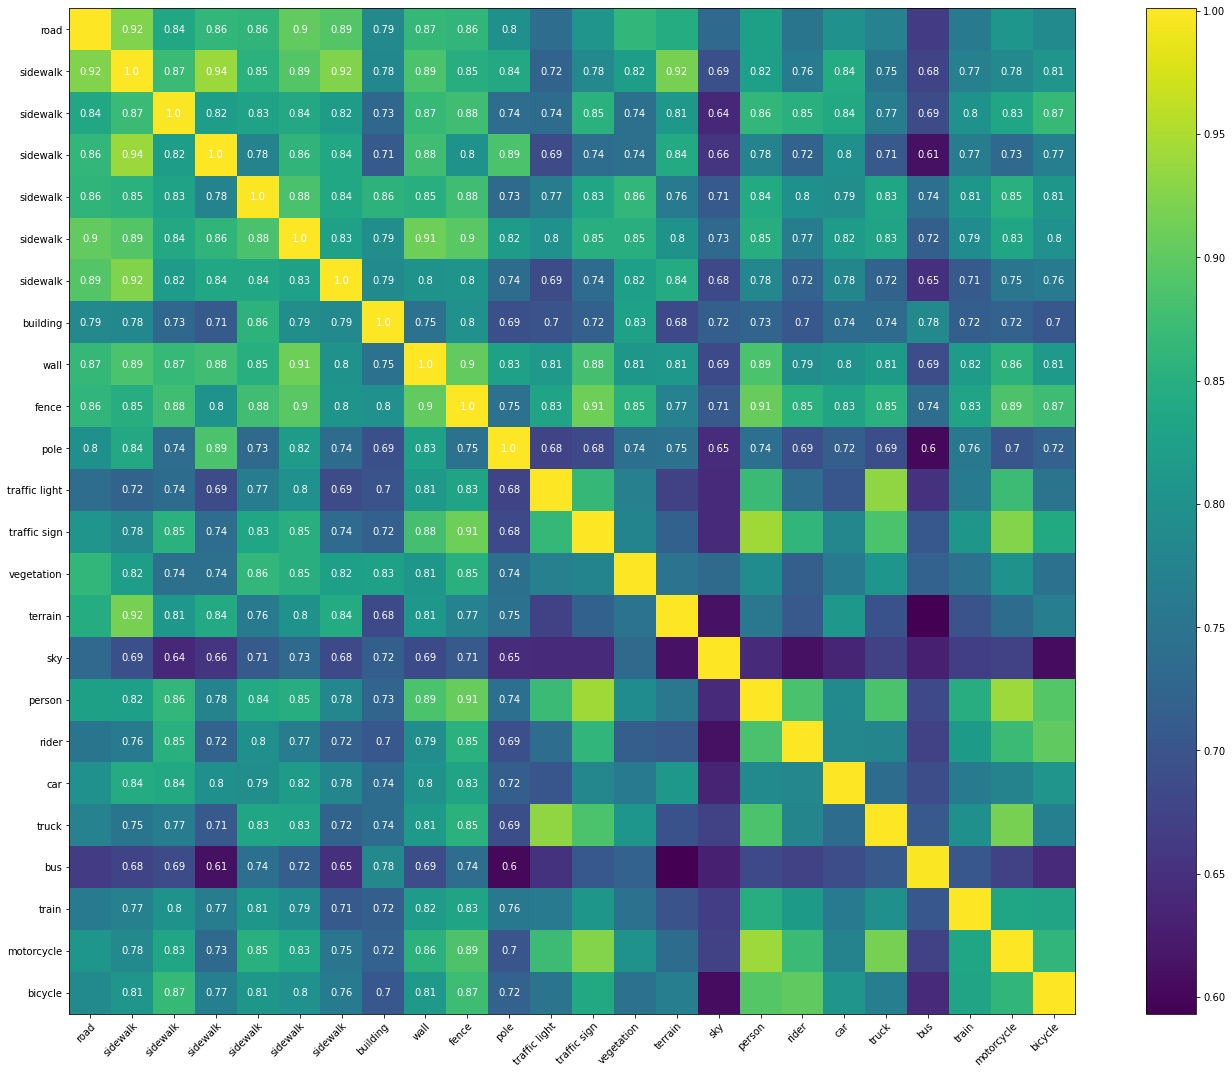

(24, 24)


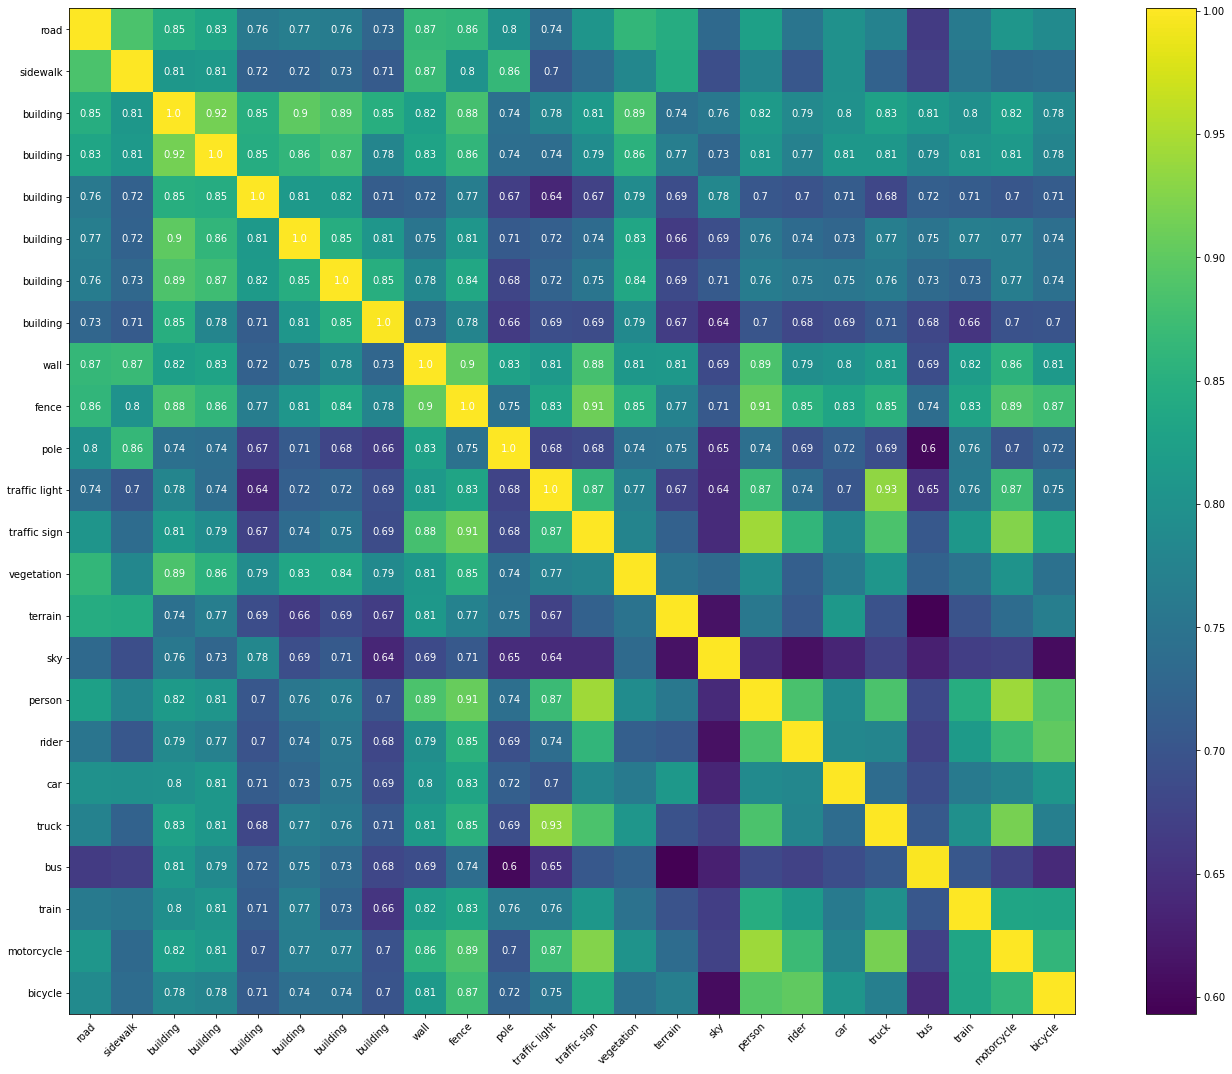

(24, 24)


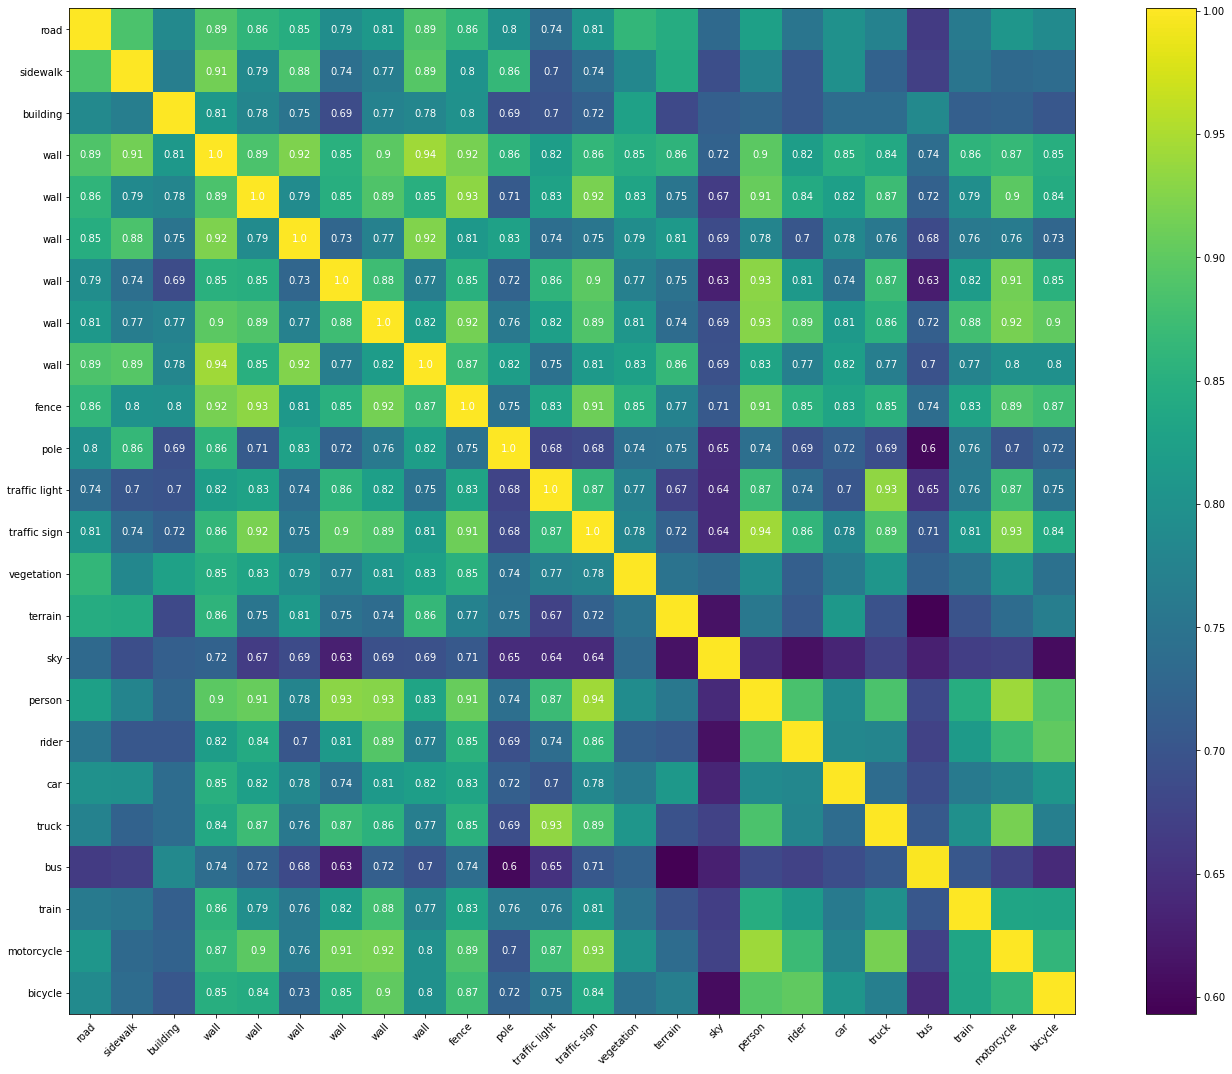

(24, 24)


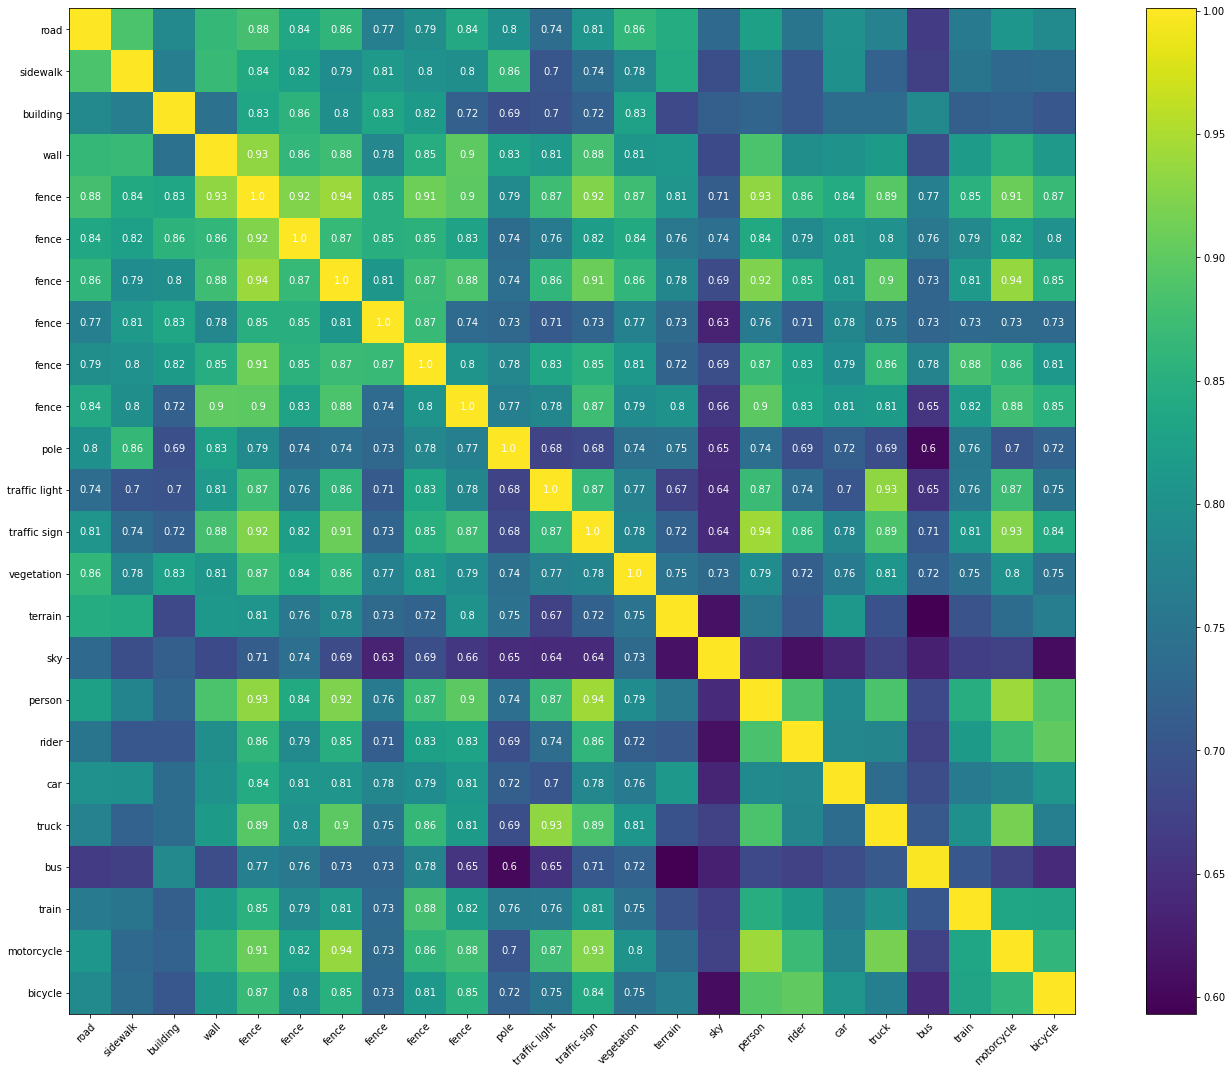

(24, 24)


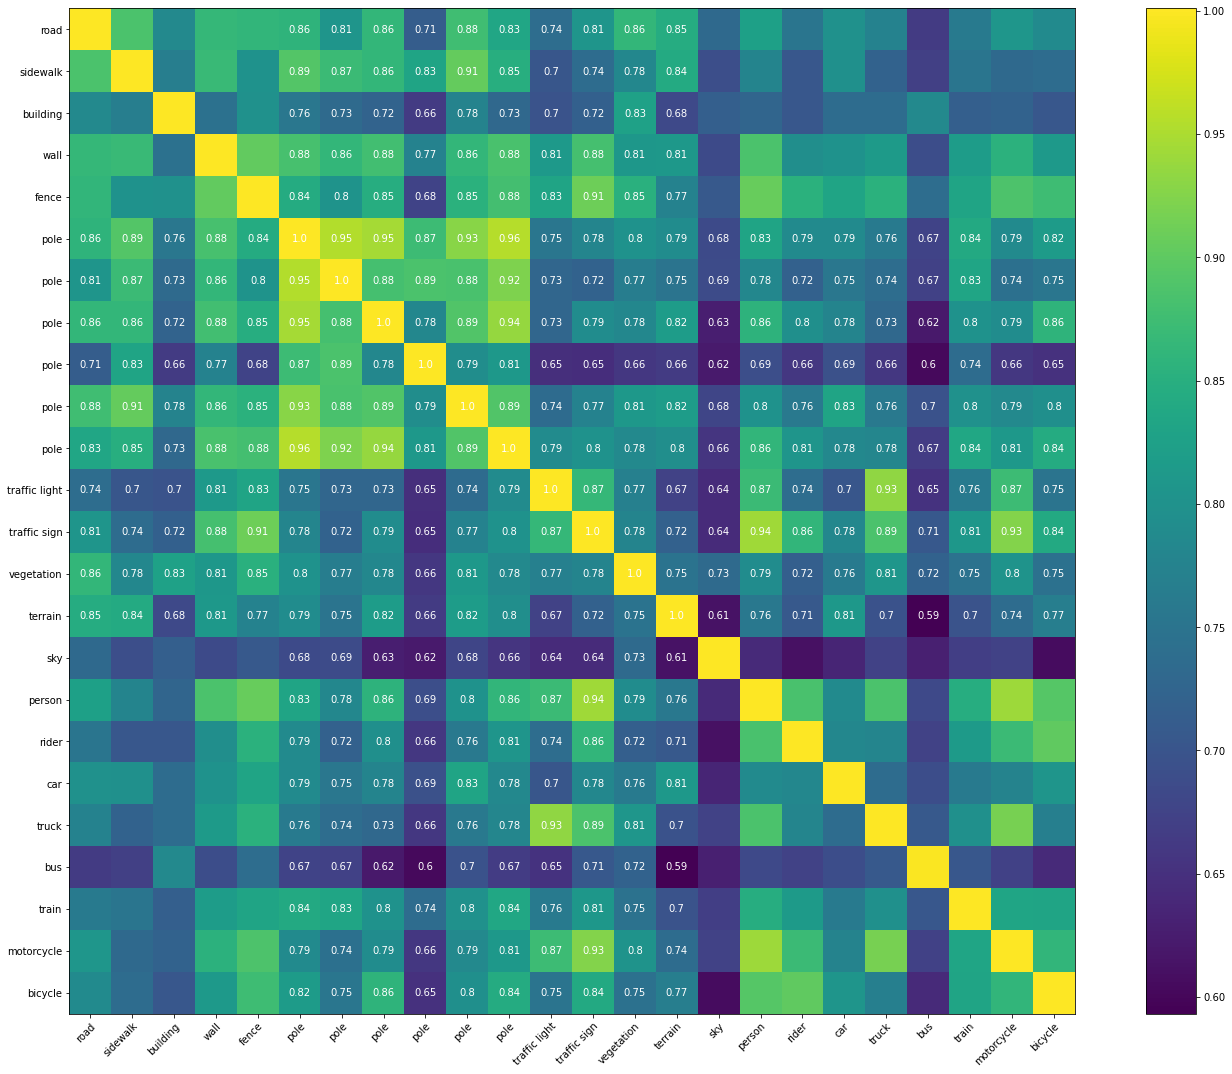

(24, 24)


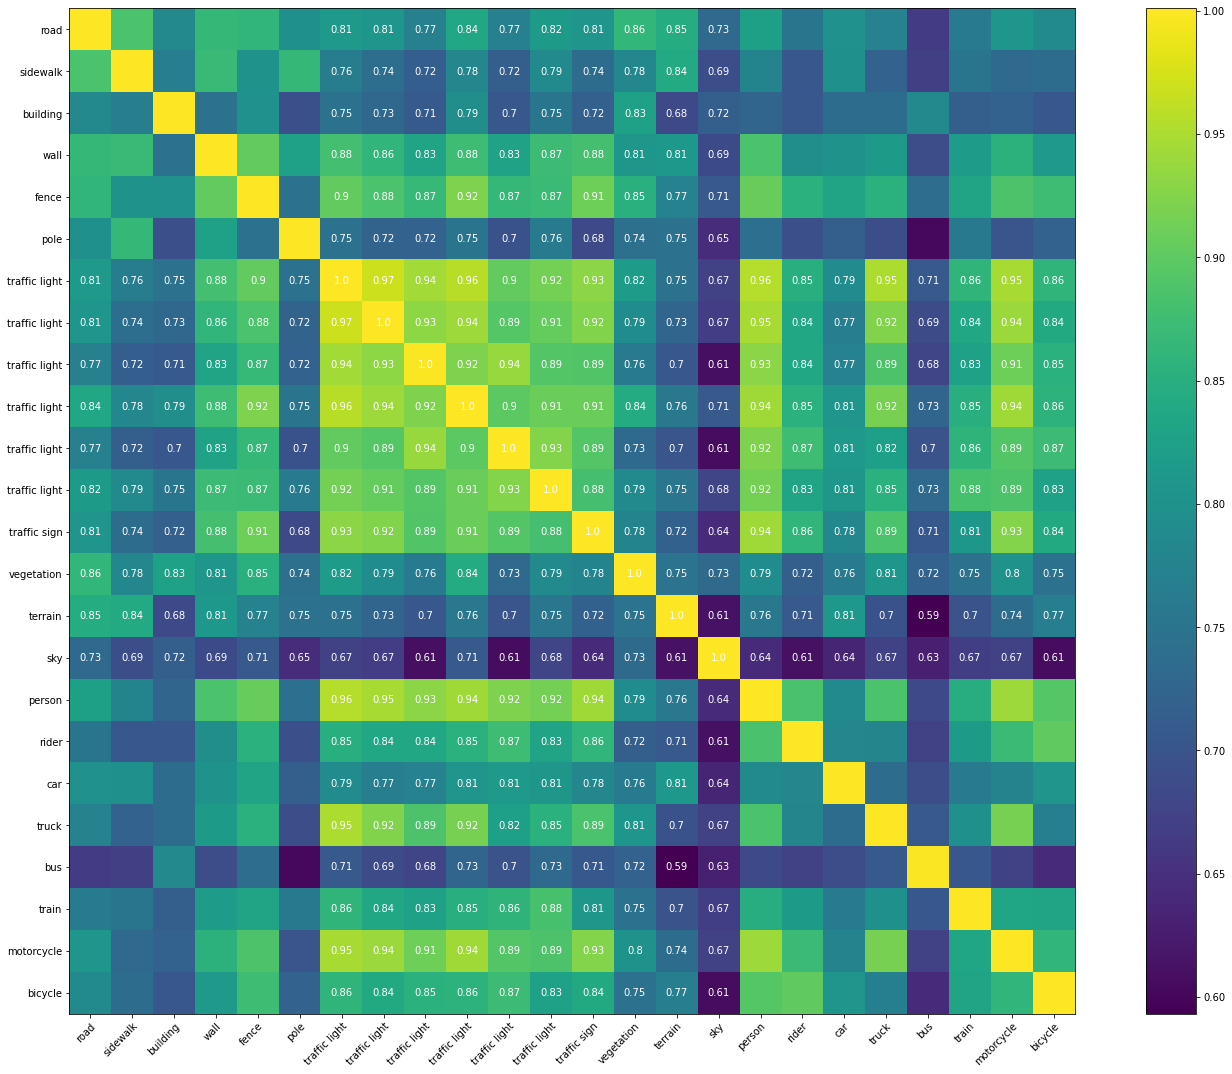

(24, 24)


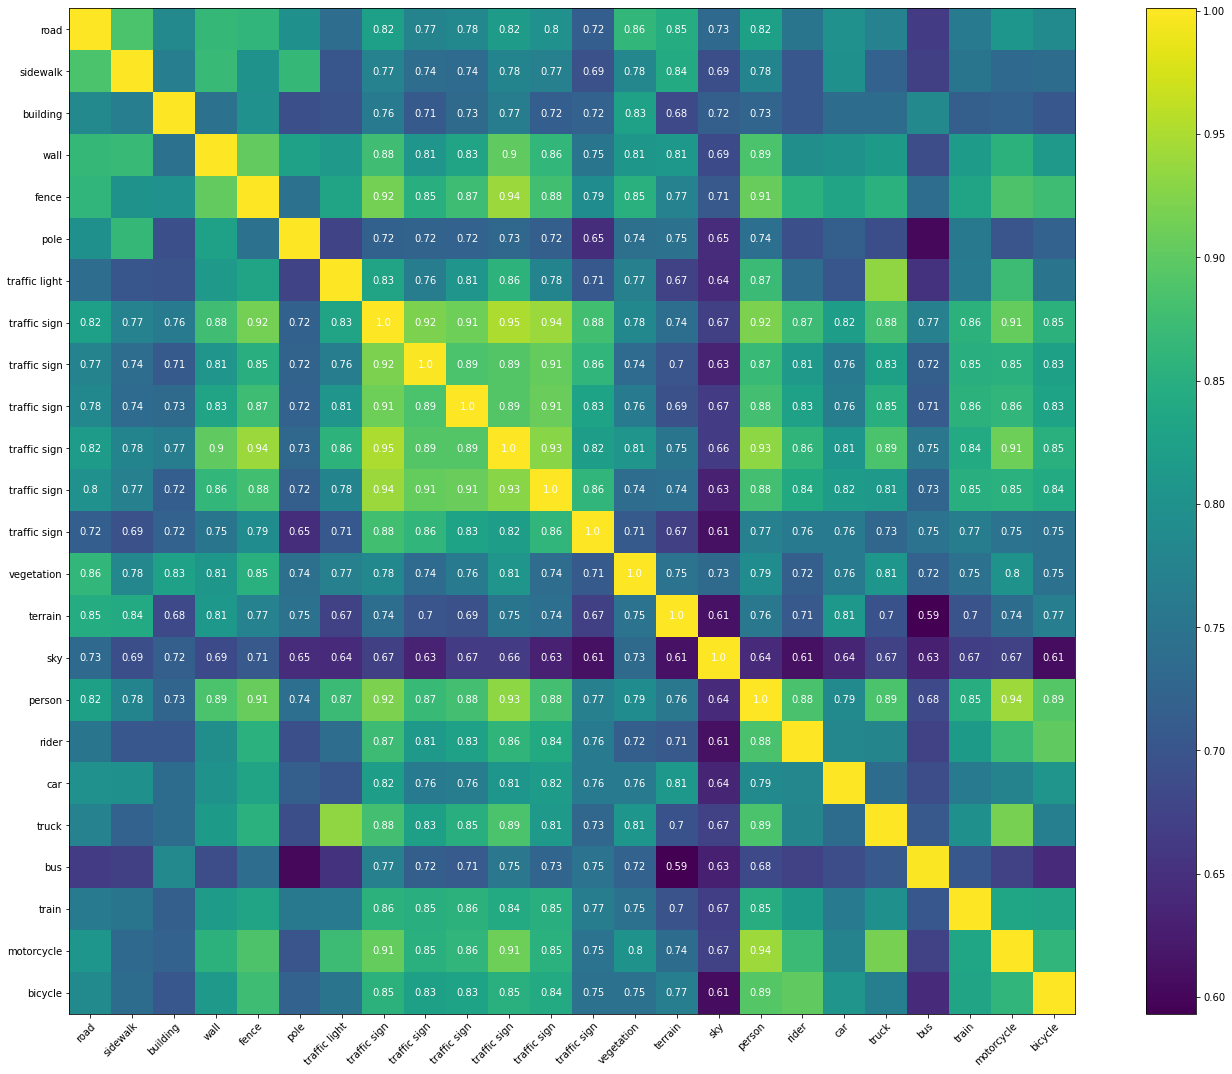

(24, 24)


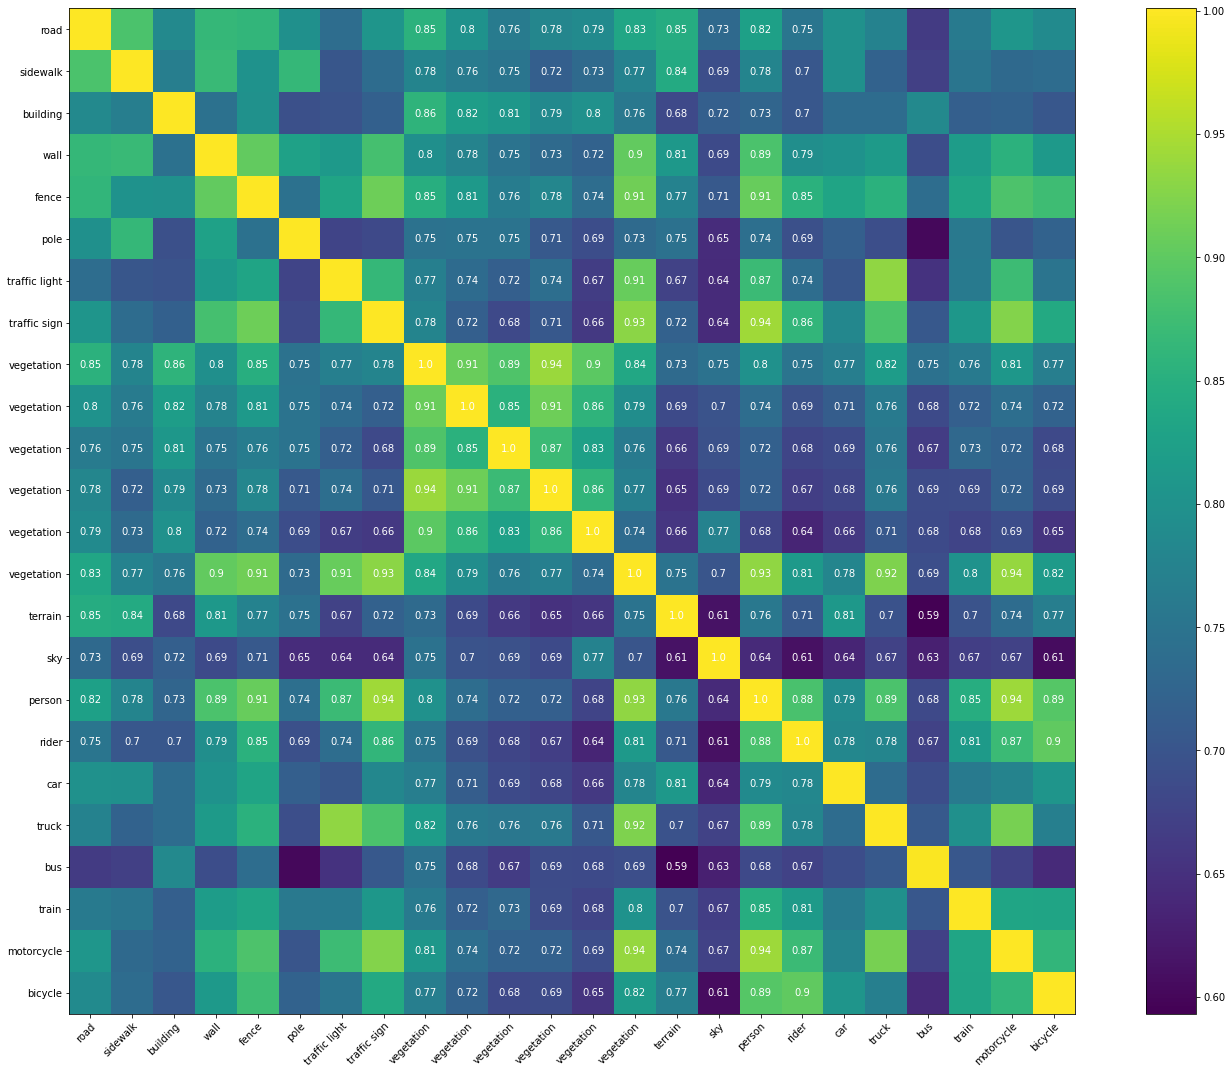

(24, 24)


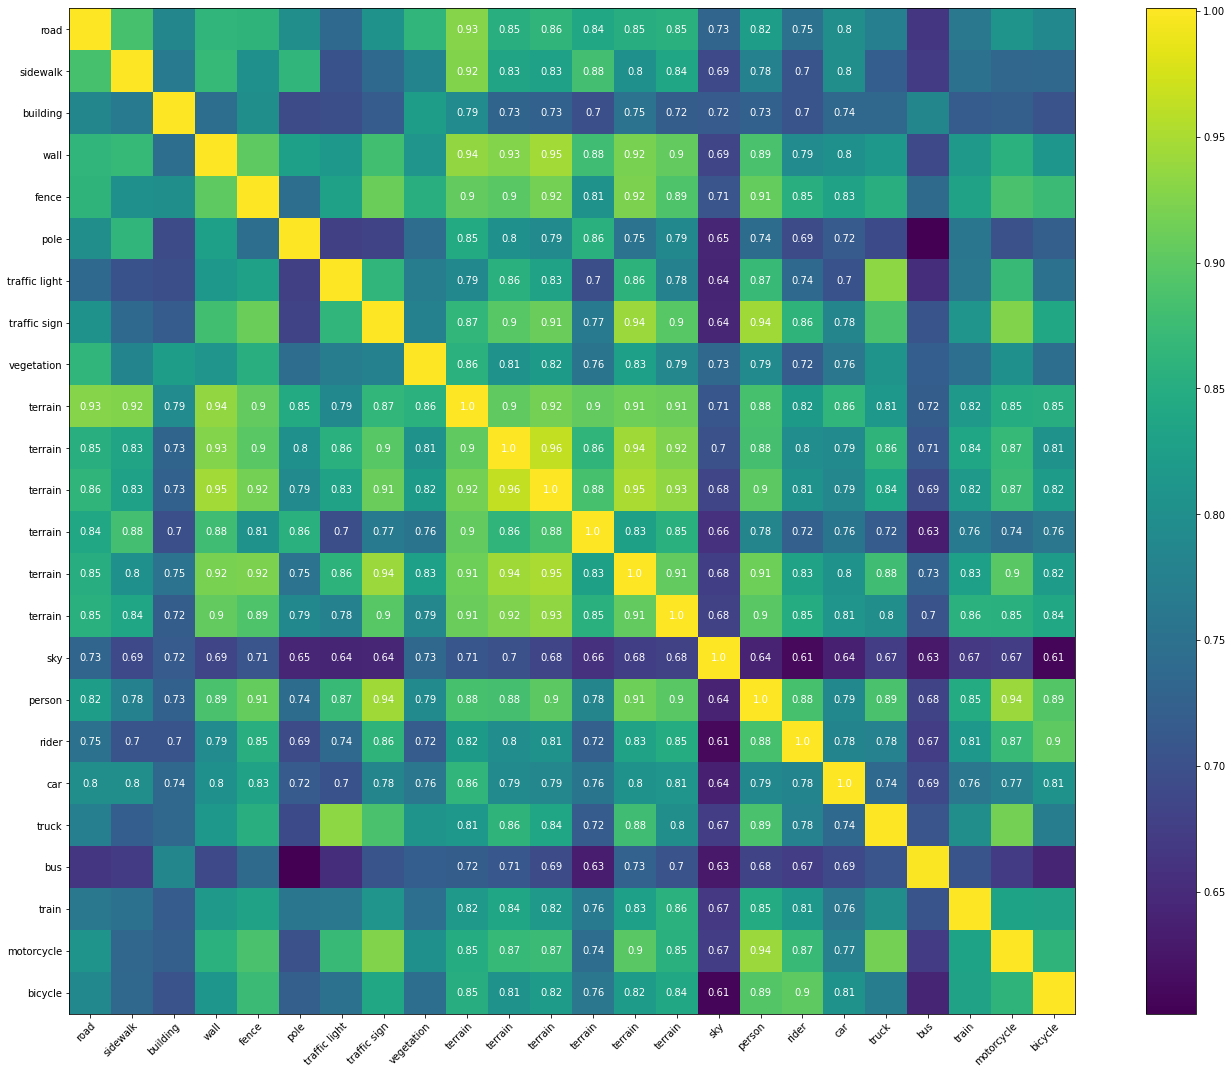

(24, 24)


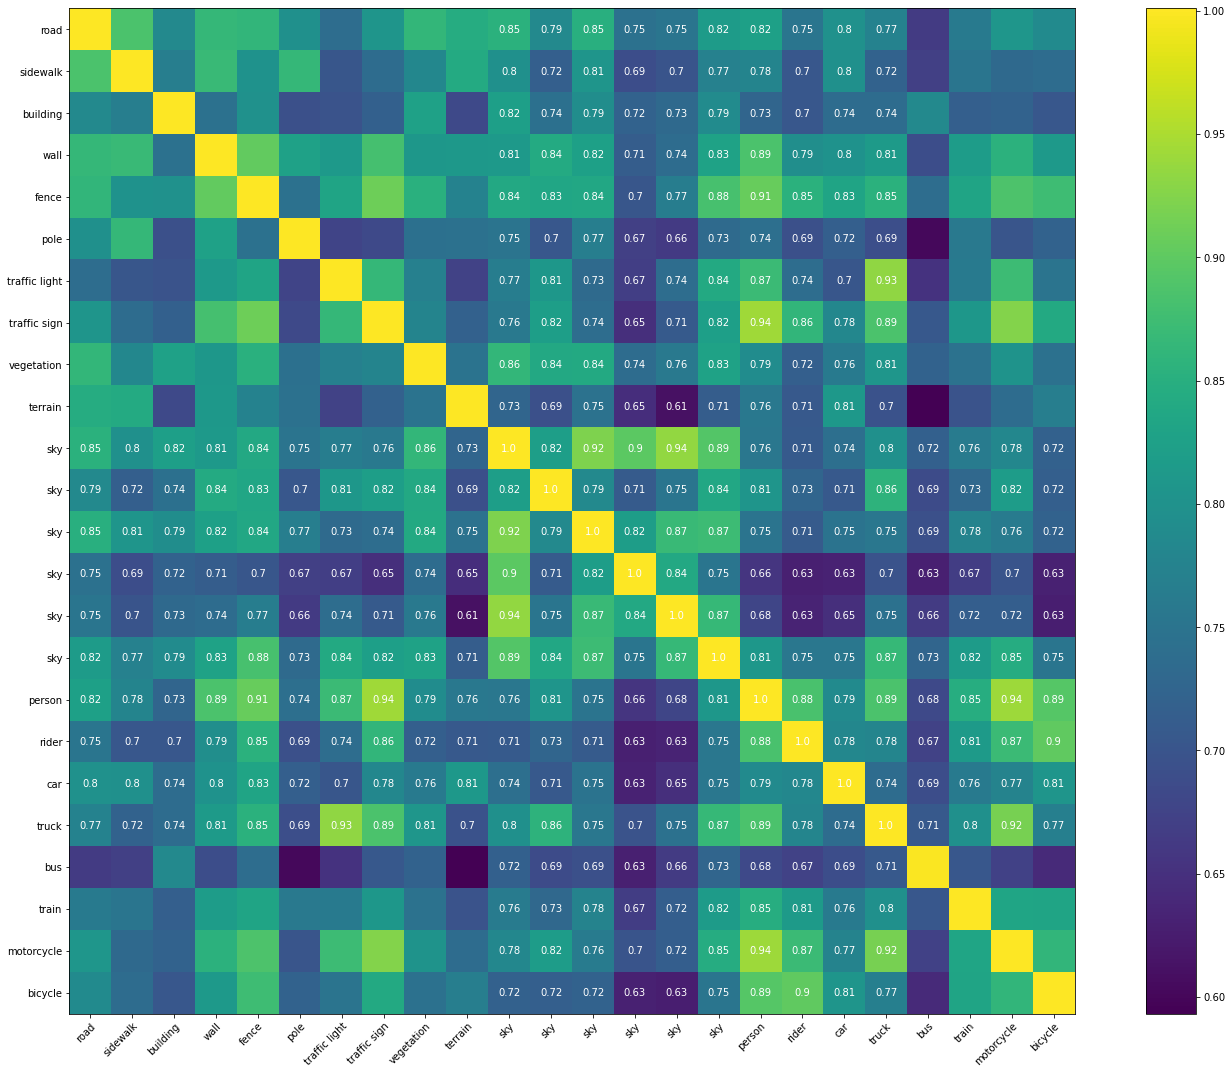

(24, 24)


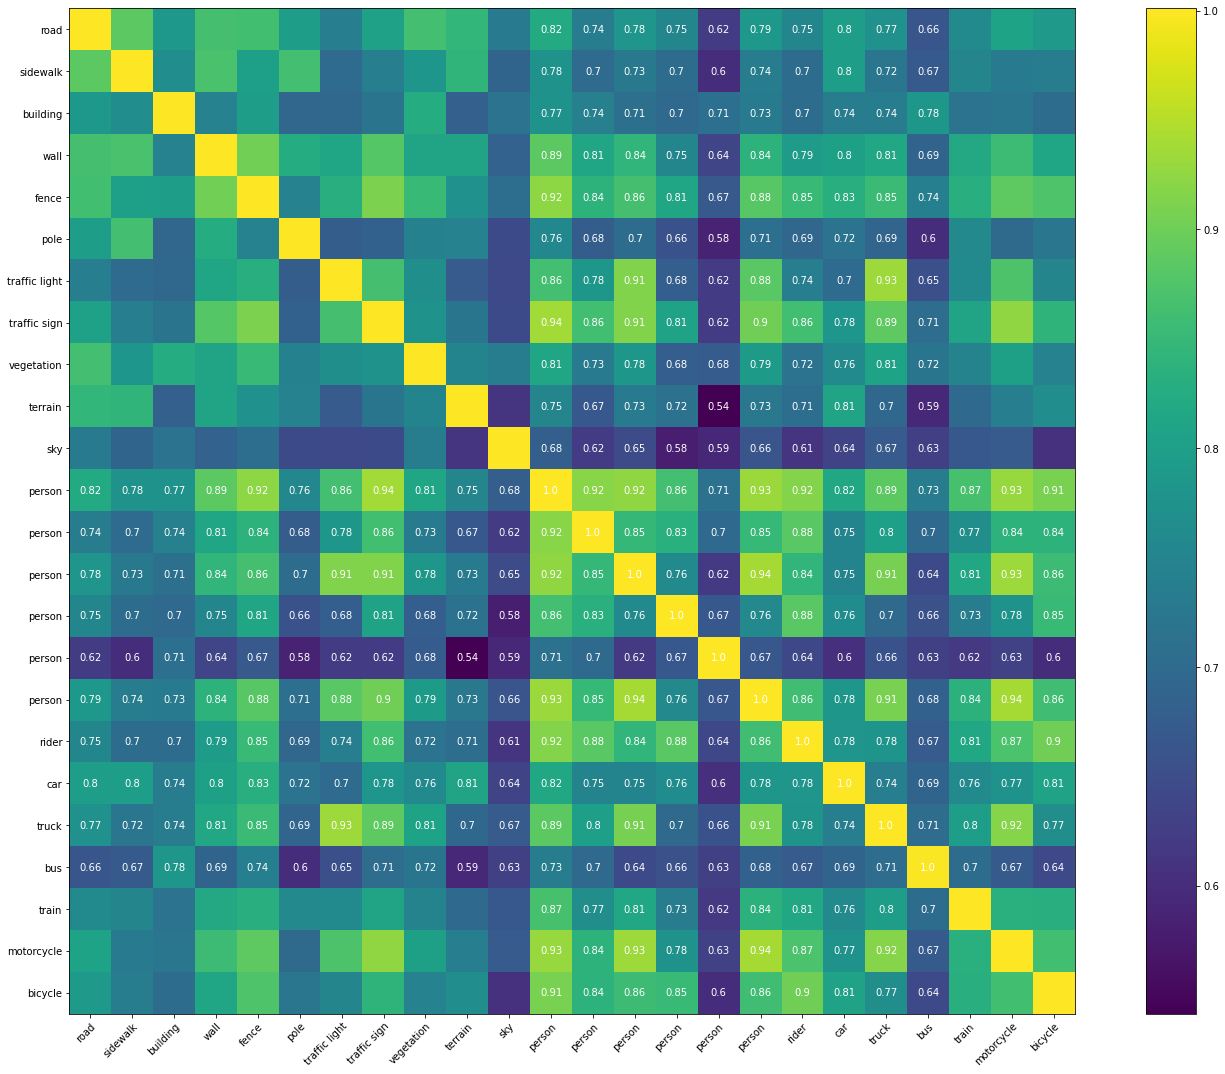

(24, 24)


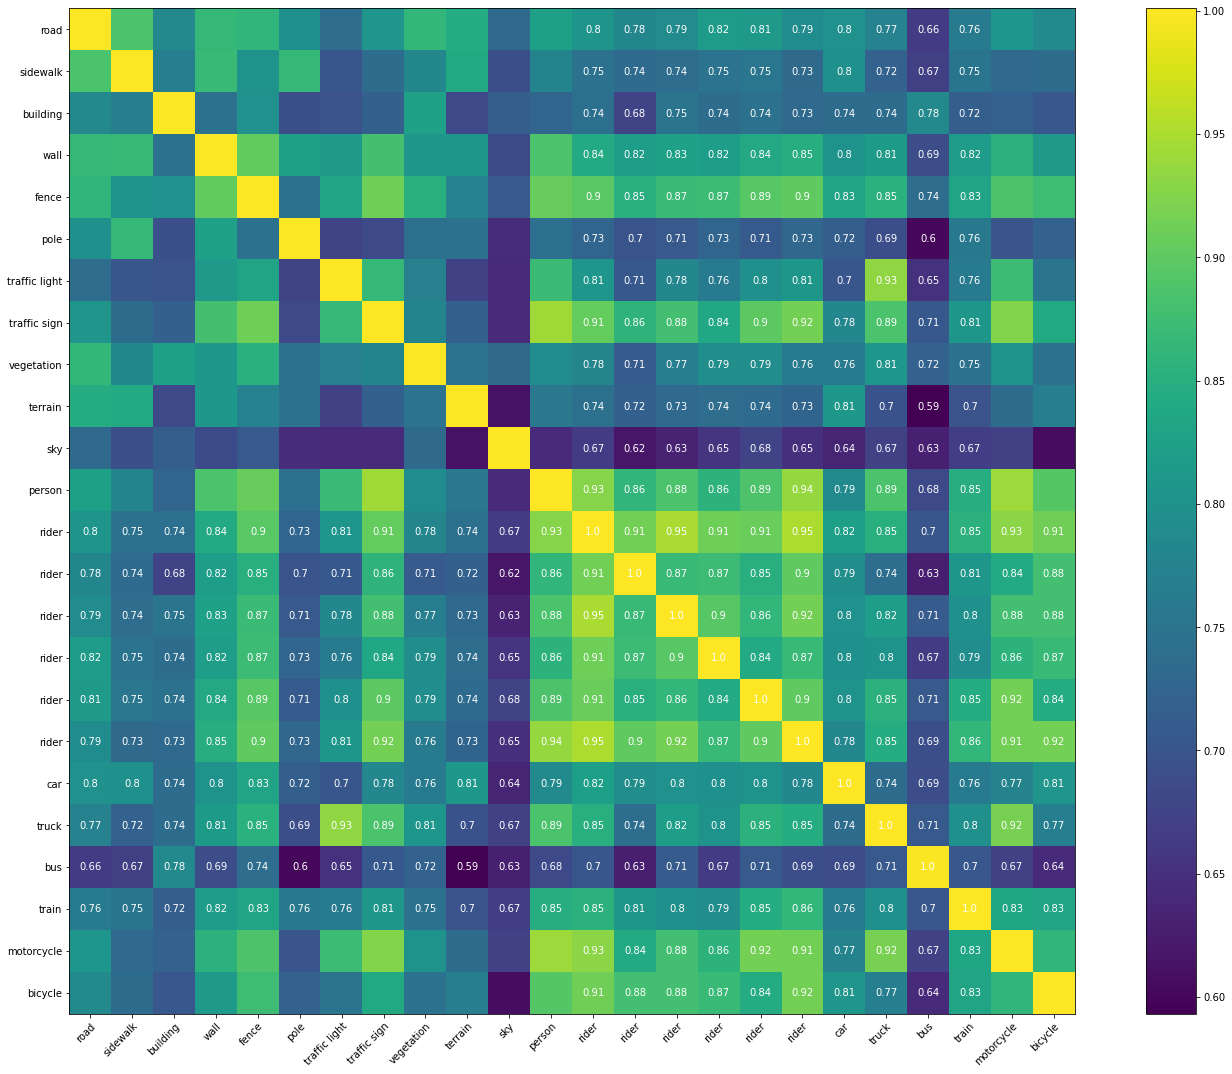

(24, 24)


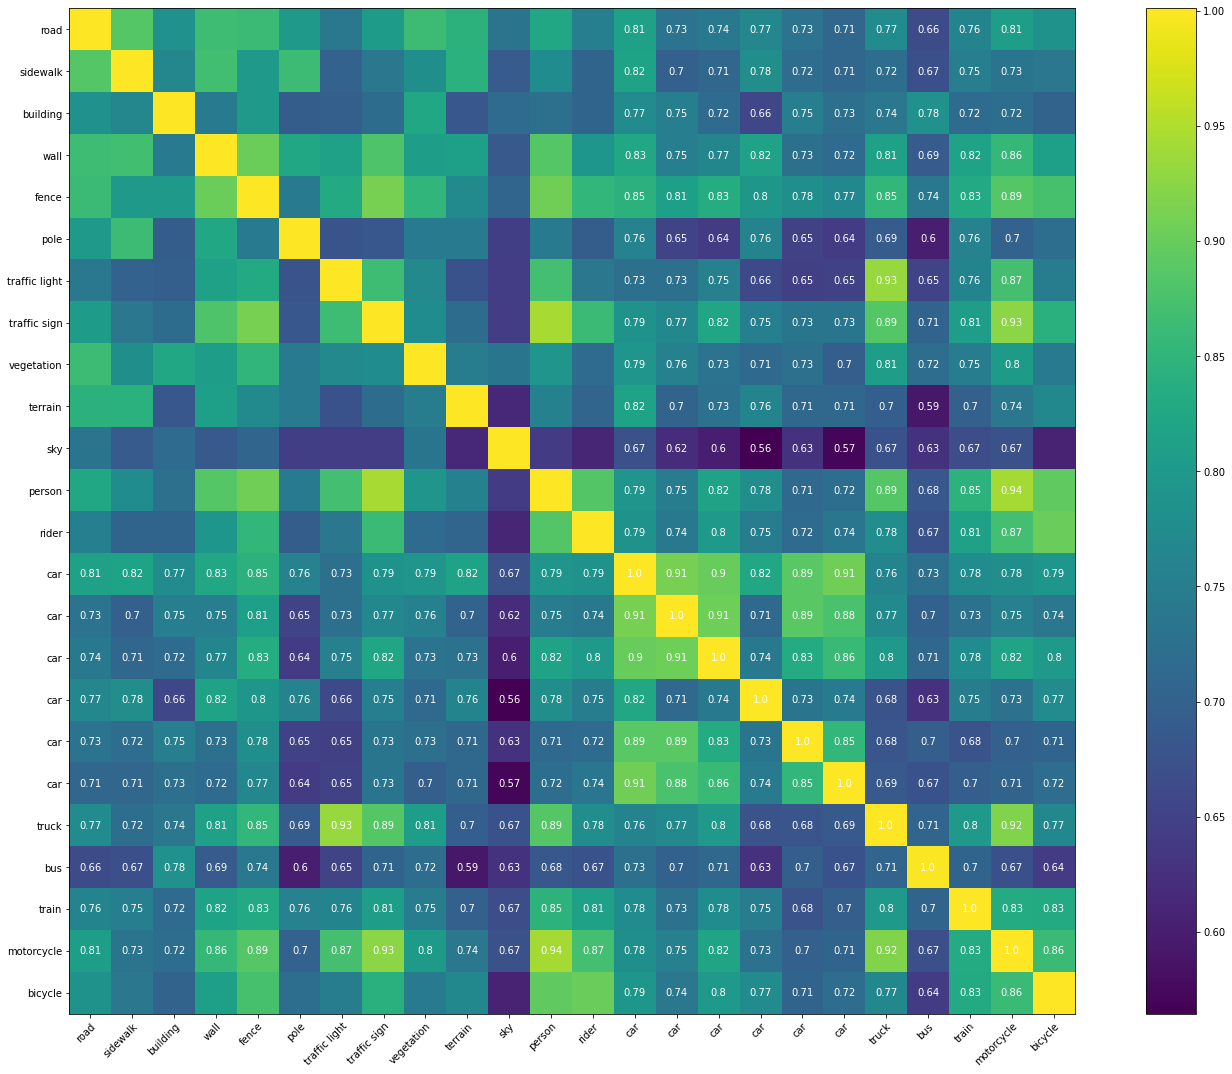

(24, 24)


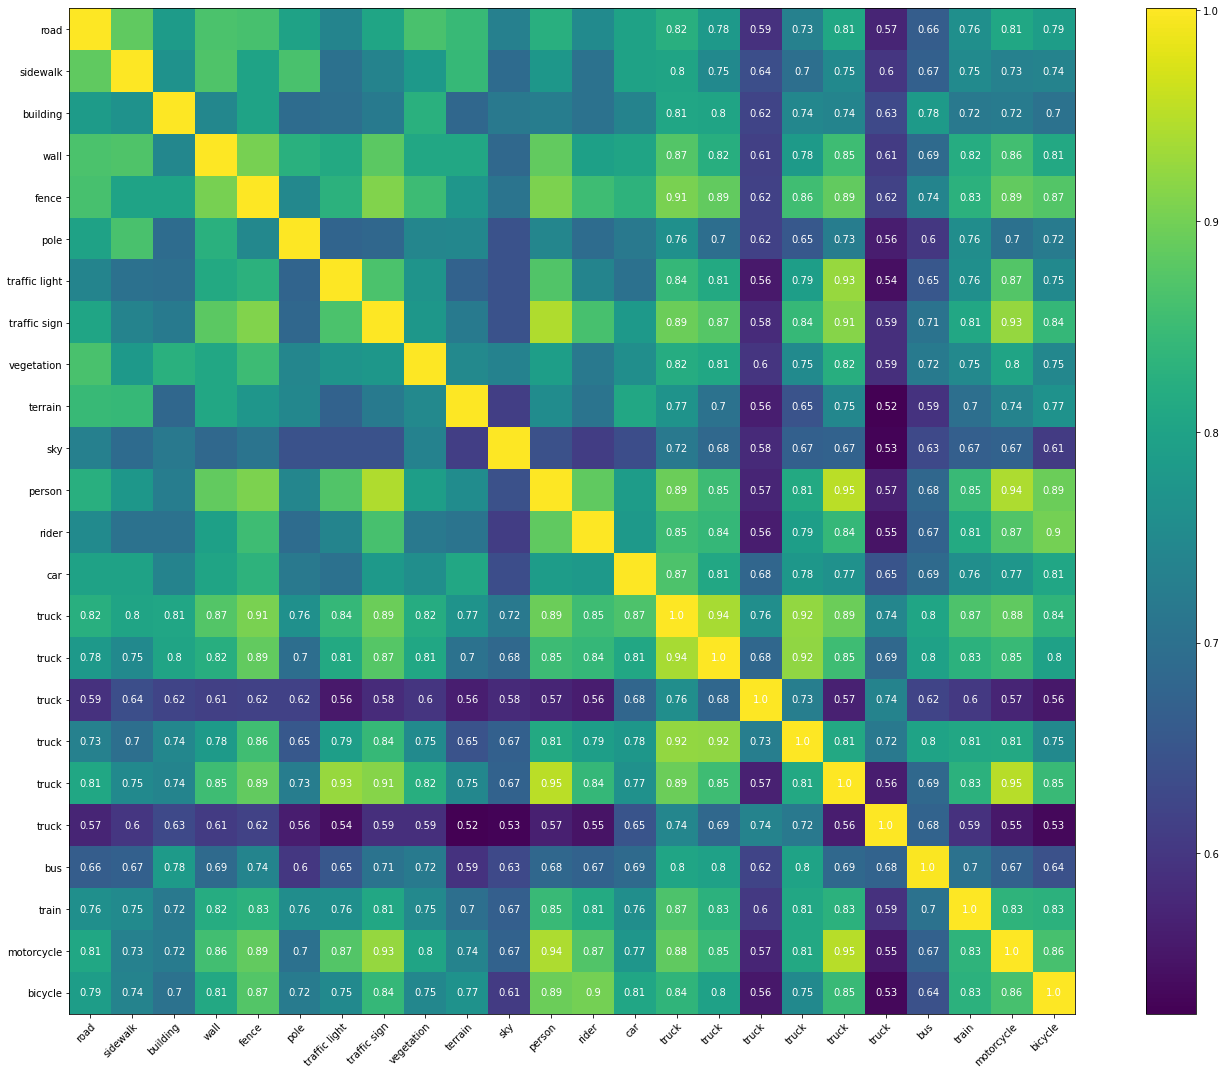

(24, 24)


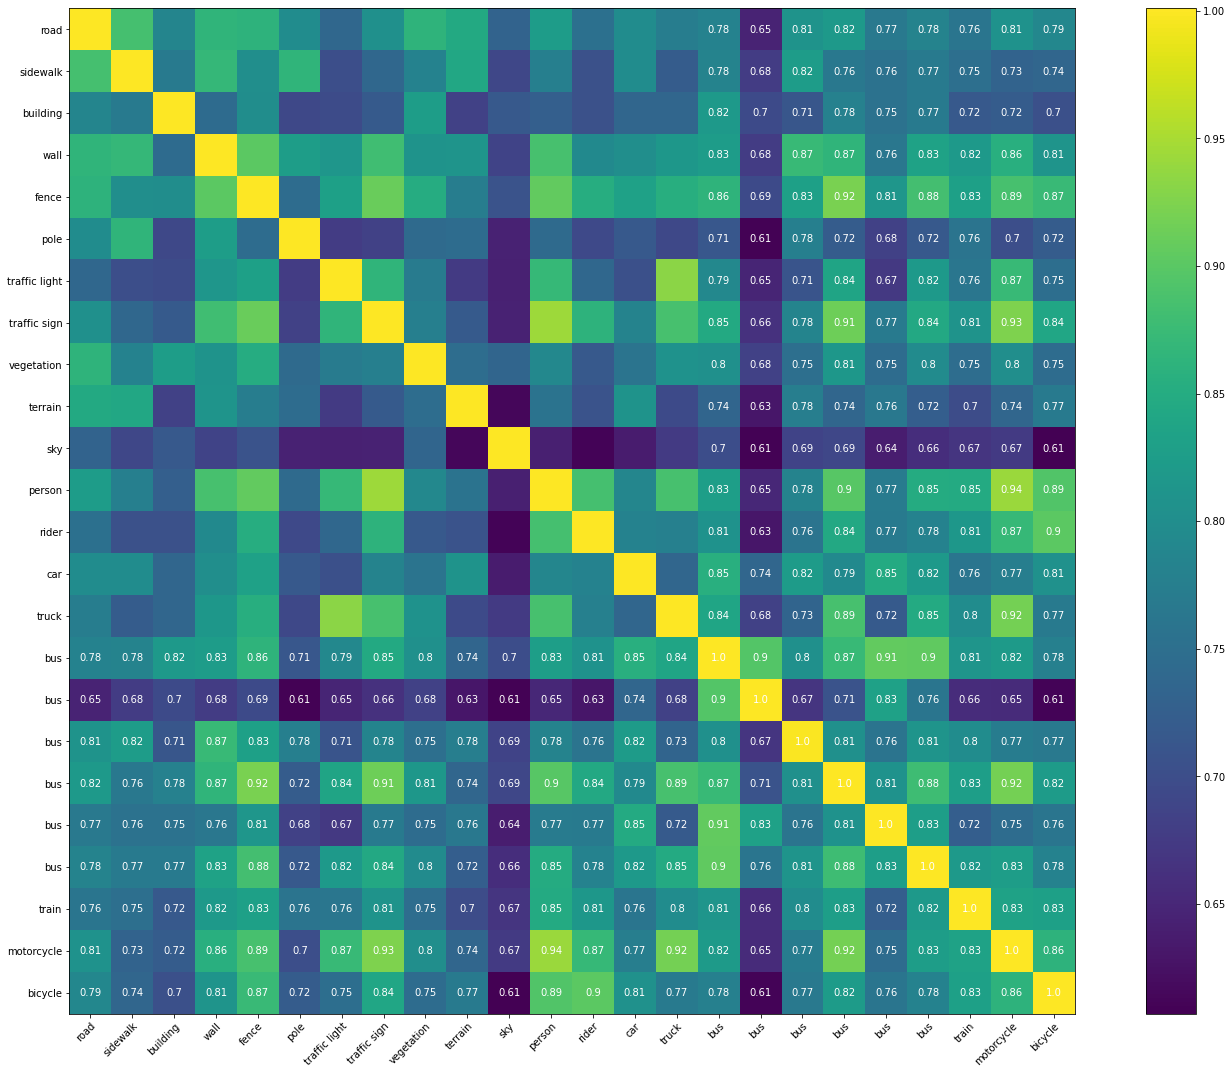

(24, 24)


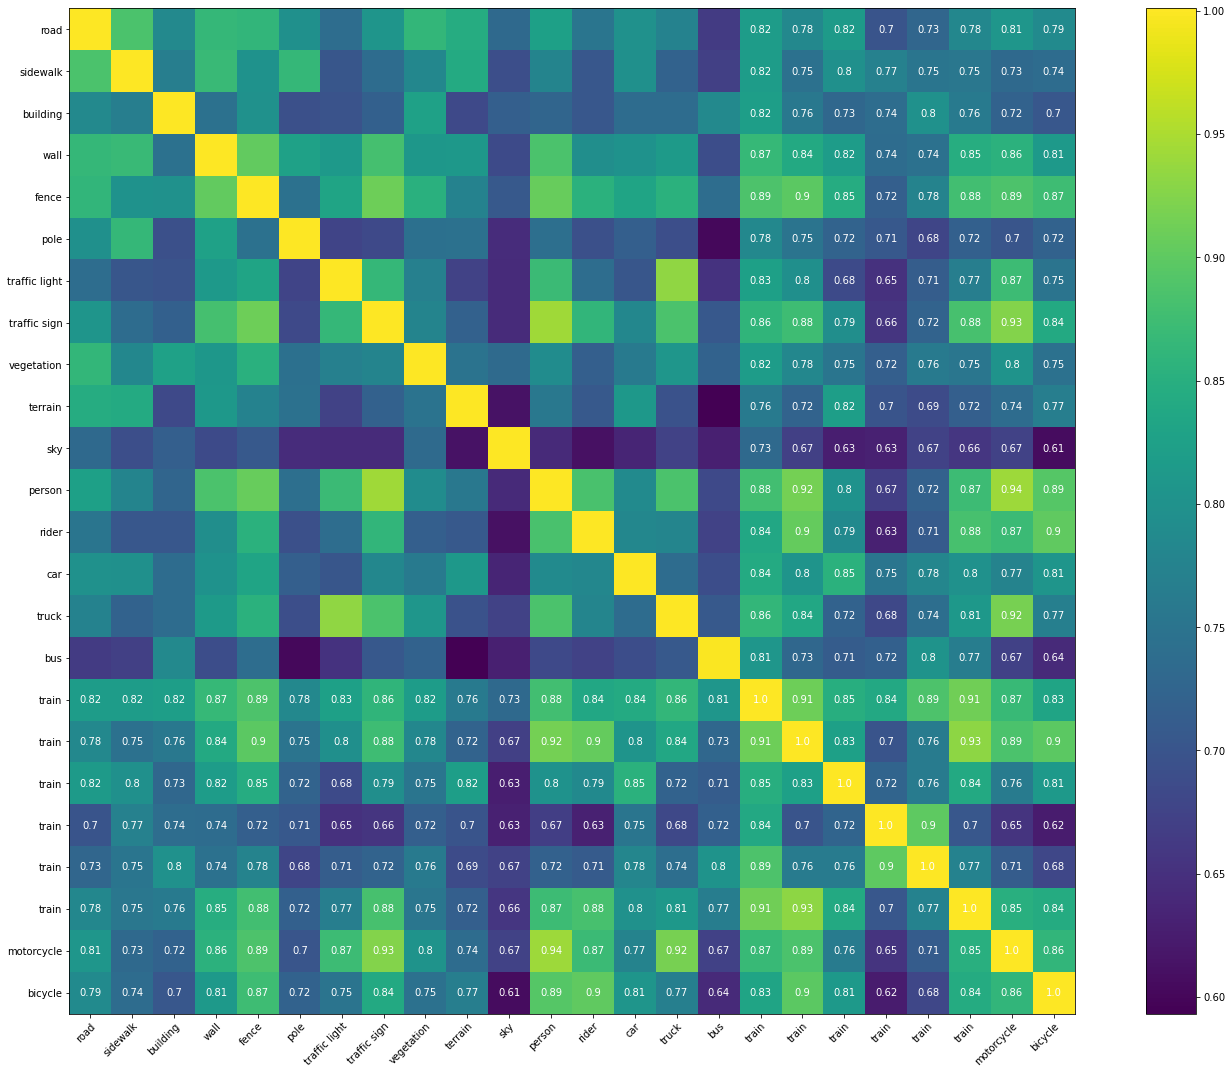

(24, 24)


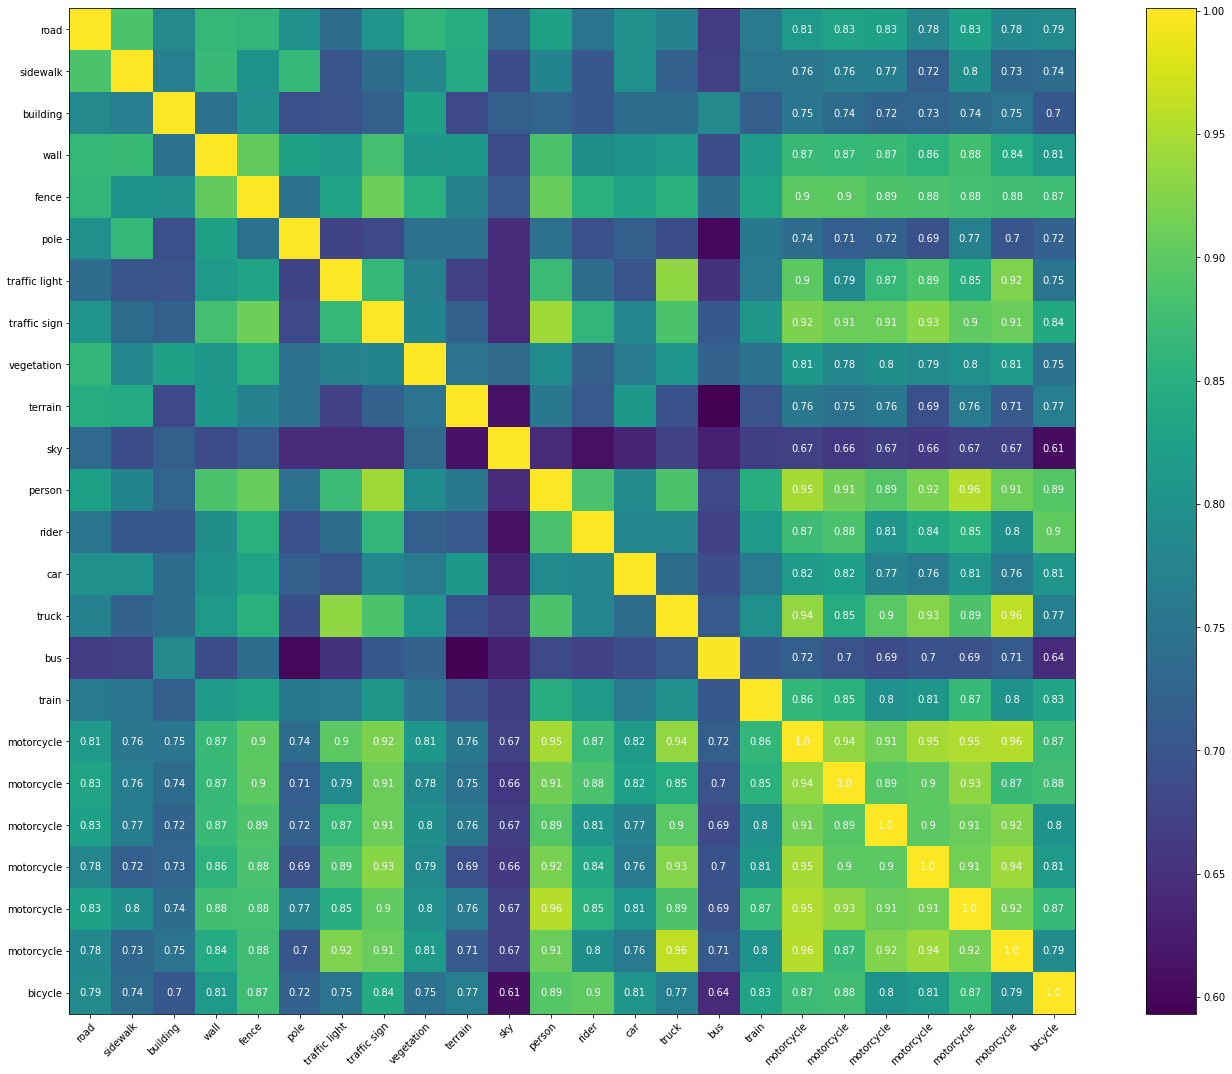

(24, 24)


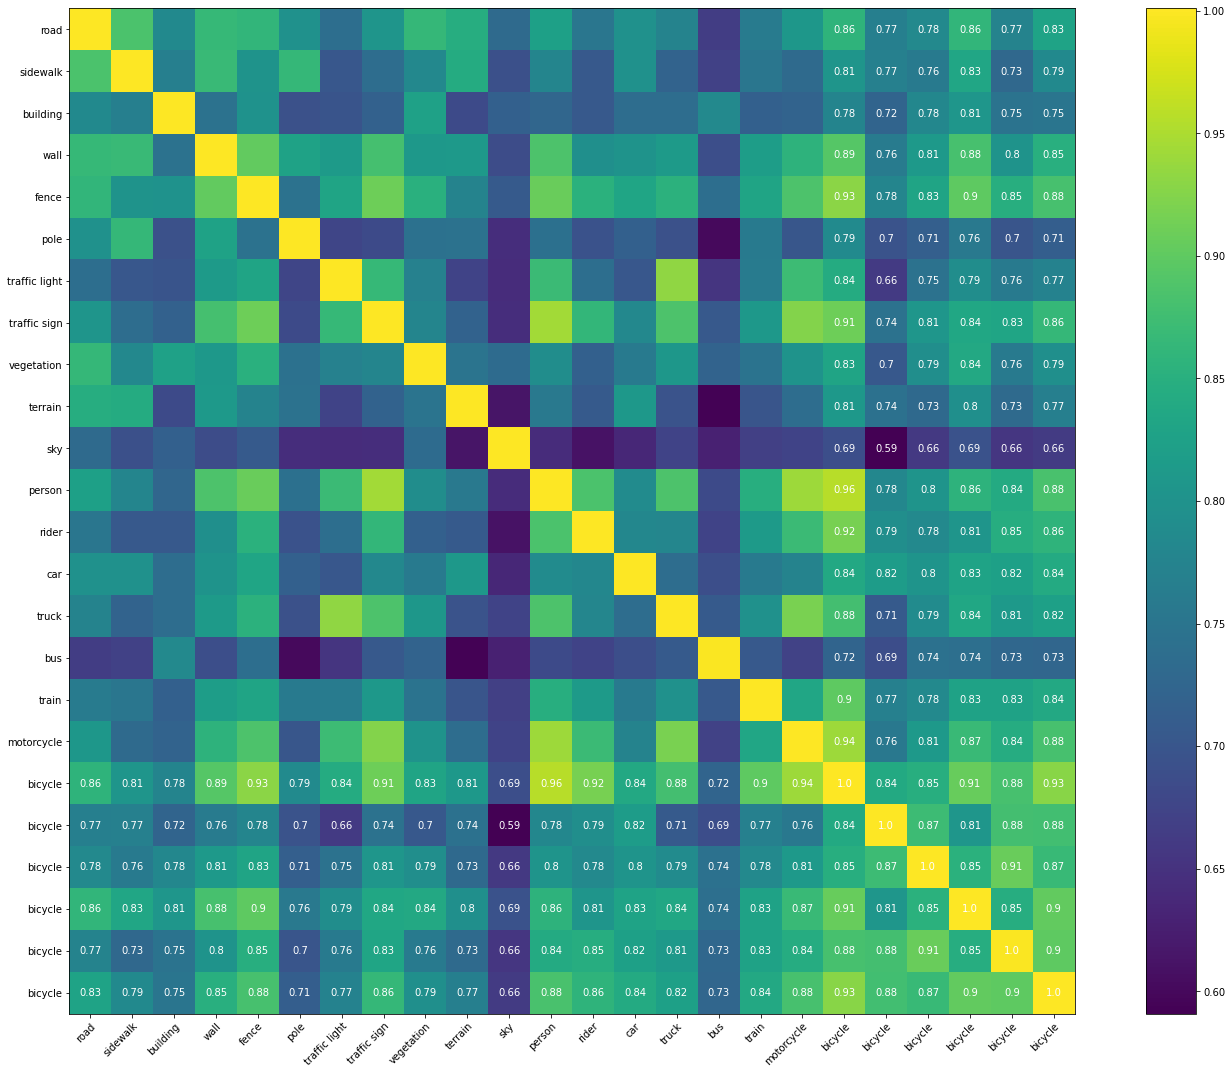

In [3]:
import matplotlib.pyplot as plt

def pairwise_cosine(data1, data2, device='cpu'):
    # transfer to device
    if device == 'cuda':
        data1, data2 = data1.cuda(), data2.cuda()

    # normalized features
    data1 = data1 / data1.norm(dim=1, keepdim=True)
    data2 = data2 / data2.norm(dim=1, keepdim=True)

    # cosine similarity as logits
    logits_per_image = data1 @ data2.t()
#     logits_per_image = logits_per_image.float() / 0.07
#     probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    return logits_per_image

                                 

# sim_matrix = pairwise_cosine(text_features, text_features)

with torch.no_grad():
    image_features_lists = []
    for i, im_lb_list in enumerate(zip(city_img_lists, city_lb_lists)):
        im_list, lb_list = im_lb_list
        image_features_list = []
        for im_path, lb in zip(im_list, lb_list):
            image = cv2.imread(im_path)
            lb = lb.numpy()
            cropped_img = crop_image_by_label_value(image, lb, i)
#             if i == 1:
#                 fig, axes = plt.subplots(1,1,figsize=(10, 5))
#                 axes.imshow(cropped_img)
#                 axes.set_title('Original Image')
#                 plt.show()
                
            im_lb = dict(im=cropped_img, lb=lb)
            im_lb = to_tensor(im_lb)
            img = im_lb['im'].cuda()
            img = F.interpolate(img.unsqueeze(0), size=(224, 224))
            image_features = model.encode_image(img)
            image_features_list.append(image_features)
#             image_features_list.append(img)
        feats = torch.cat(image_features_list, dim=0)
        image_features_lists.append(feats.unsqueeze(0))
    feats = torch.cat(image_features_lists, dim=0)
    print(feats.shape)
        
    lb_name_ori = ["road", "sidewalk", "building", "wall", "fence", "pole", "traffic light", "traffic sign", "vegetation", "terrain", "sky", "person", "rider", "car", "truck", "bus", "train", "motorcycle", "bicycle"]
    for i in range(len(image_features_lists)):
        before_feats = feats[:i, 0, :].squeeze(1)
        after_feats = feats[i+1:, 0, :].squeeze(1)

        proto_feats = torch.mean(feats[i,:5,:], dim=0, keepdim=True)
        expand_feat = torch.cat([before_feats, proto_feats, feats[i, 5:, :], after_feats], dim=0)
        
        lb_name = lb_name_ori[:i]
        for _ in range(6):
            lb_name += [lb_name_ori[i]]
        lb_name += lb_name_ori[i+1:]
#         promo_lb_name = ["a photo of " + name + "." for name in lb_name_ori]
#         text = clip.tokenize(promo_lb_name).cuda()
#         text_features = model.encode_text(text)
        
        sim_matrix = pairwise_cosine(expand_feat, expand_feat).cpu().numpy()
#         logits_per_image, logits_per_text = model(expand_feat, text)
#         sim_matrix = logits_per_image.softmax(dim=-1).cpu().numpy()
        print(sim_matrix.shape)
        data = sim_matrix.astype(np.float32)
#         print(lb_name)
        
        # 这里是创建一个画布
        fig, ax = plt.subplots(figsize=(20,15))
        im = ax.imshow(data)

        # 这里是修改标签
        # We want to show all ticks...
        ax.set_xticks(np.arange(len(lb_name)))
        ax.set_yticks(np.arange(len(lb_name)))
        # ... and label them with the respective list entries
        ax.set_xticklabels(lb_name)
        ax.set_yticklabels(lb_name)

        # 因为x轴的标签太长了，需要旋转一下，更加好看
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")


        # 添加每个热力块的具体数值
        # Loop over data dimensions and create text annotations.
#         for pi in range(len(lb_name)):
#             for pj in range(len(lb_name_ori)):
#                 text = ax.text(pj, pi, round(data[pi, pj],2),
#                                ha="center", va="center", color="w")
        for pi in range(len(lb_name)):
            for pj in range(len(lb_name)):
                if (pi < i+10 and pi >= i) or (pj < i+10 and pj >= i):
                    text = ax.text(pj, pi, round(data[pi, pj],2),
                                   ha="center", va="center", color="w")
        # ax.set_title("Harvest of local farmers (in tons/year)")
        fig.tight_layout()
        plt.colorbar(im)

        plt.show()
        #         print(sim_matrix)
        #         print(sim_matrix.shape)




['road', 'road', 'road', 'road', 'road', 'road', 'road', 'road', 'road', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']
28
torch.Size([28, 28])


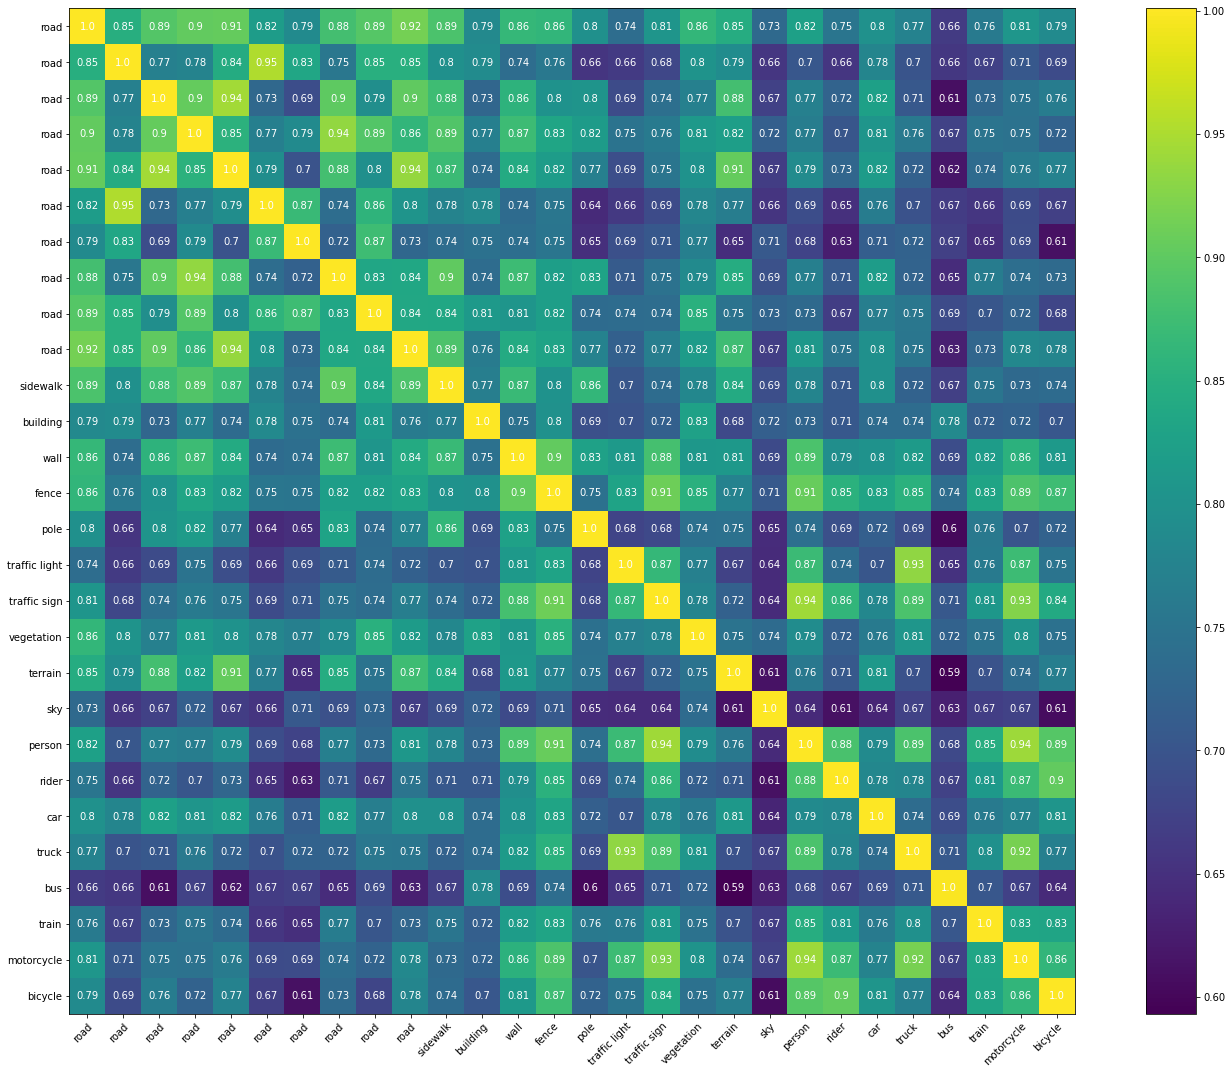

In [19]:
# 这里是创建一个数据
# lb_name = configer.get("unify_classes_name")
data = sim_matrix.detach().cpu().numpy().astype(np.float32)

lb_name_ori = ["road", "sidewalk", "building", "wall", "fence", "pole", "traffic light", "traffic sign", "vegetation", "terrain", "sky", "person", "rider", "car", "truck", "bus", "train", "motorcycle", "bicycle"]
lb_name = 
lb_name.extend(lb_name2)
print(lb_name)
print(len(lb_name))
print(sim_matrix.shape)
# vegetables = ["cucumber", "tomato", "lettuce", "asparagus",
#               "potato", "wheat", "barley"]
# farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
#            "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

# harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
#                     [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
#                     [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
#                     [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
#                     [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
#                     [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
#                     [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])

# 这里是创建一个画布
fig, ax = plt.subplots(figsize=(20,15))
im = ax.imshow(data)

# 这里是修改标签
# We want to show all ticks...
ax.set_xticks(np.arange(len(lb_name)))
ax.set_yticks(np.arange(len(lb_name)))
# ... and label them with the respective list entries
ax.set_xticklabels(lb_name)
ax.set_yticklabels(lb_name)

# 因为x轴的标签太长了，需要旋转一下，更加好看
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


# 添加每个热力块的具体数值
# Loop over data dimensions and create text annotations.
for i in range(len(lb_name)):
    for j in range(len(lb_name)):
        text = ax.text(j, i, round(data[i, j],2),
                       ha="center", va="center", color="w")
# ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.colorbar(im)

plt.show()



True
127786
(551, 211, 362, 353)


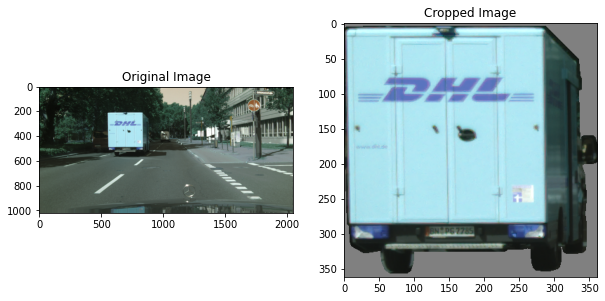

In [12]:
def crop_image_by_label_value(img, label, label_value):
    # 将标签二值化
    binary = np.zeros_like(label)
    binary[label == label_value] = 255

    binary = cv2.convertScaleAbs(binary)
    
    # 执行闭运算操作
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    # 计算轮廓
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    
#     # 找到覆盖所有轮廓的最小矩形
#     max_rect = cv2.minAreaRect(np.concatenate(contours))
    
#     # 获取最大包围盒的坐标
#     x, y, w, h = cv2.boundingRect(np.int0(cv2.boxPoints(max_rect)))
#     print(x, y, w, h)

    # 计算每个包围盒的面积并找到面积最大的包围盒
    max_area = 0
    max_bbox = None
    for contour in contours:
        bbox = cv2.boundingRect(contour)
        area = bbox[2] * bbox[3]
        if area > max_area:
            max_area = area
            max_bbox = bbox
    
    print(max_area)
    print(max_bbox)

    # 如果没有找到任何包围盒，返回空图像
    if max_bbox is None:
        return np.zeros_like(image)

    # 裁剪图像
    x, y, w, h = max_bbox

#     # 获取包围盒
#     x, y, w, h = cv2.boundingRect(contours[4])
#     print(x, y, w, h)
    
    # 裁剪图像
    # print(img.shape)
    cropped = img[y:y+h, x:x+w, :]
    
    # 将不属于该标签的像素点替换为指定的值
    label_roi = binary[y:y+h, x:x+w]
    
    k = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(label_roi, kernel=k)
    
    
    mask = np.ones_like(cropped, dtype=bool)
    mask[dilated != 255] = False
    cropped[~mask] = 128
    
    h, w, _ = cropped.shape
    if h < w:
        top_padding = (w - h) // 2
        bottom_padding = w - h - top_padding
        cropped = cv2.copyMakeBorder(cropped, top_padding, bottom_padding, 0, 0, cv2.BORDER_CONSTANT, value=[128, 128, 128])
    elif h > w:
        left_padding = (h - w) // 2
        right_padding = h - w - left_padding
        cropped = cv2.copyMakeBorder(cropped, 0, 0, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[128, 128, 128])
        
    # 返回裁剪后的图像
    return cropped

im_path = city_img_lists[14][6]
lb = city_lb_lists[14][6].numpy()
print((lb == 14).any())

ori_image = cv2.imread(im_path)
# 显示裁剪前后的图像
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(ori_image)
axes[0].set_title('Original Image')

cropped_img = crop_image_by_label_value(ori_image, lb, 14)

im_lb = dict(im=cropped_img, lb=lb)
im_lb = to_tensor(im_lb)
img = im_lb['im'].cuda()
# _, h, w = img.shape
# print(img.shape)
img = F.interpolate(img.unsqueeze(0), size=(224, 224))
# if h > w:
#     resize_w = int(224 * w / h)
#     img = F.interpolate(img.unsqueeze(0), size=(224, resize_w))
#     left_padding = (224 - resize_w) /2
#     right_padding = 224 - resize_w - left_padding
#     pad = nn.ZeroPad2d(padding=(left_padding, right_padding, 0, 0), value=0)
# else:
#     img = F.interpolate(img.unsqueeze(0), size=(int(224 * h / w), 224))
    


# lb = im_lb['lb']




axes[1].imshow(cropped_img)
axes[1].set_title('Cropped Image')
plt.show()